In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
sys.path.append(r'modules')
from pathlib import Path

import particleanalyzer as pa
import imgfileutils as imf
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
from skimage.external import tifffile
from skimage.util.dtype import dtype_range
from skimage import exposure
from skimage.util import invert
from skimage import img_as_ubyte
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from skimage.color import label2rgb
from skimage.segmentation import clear_border
from skimage.filters import threshold_otsu
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import seaborn as sns
from apeer_ometiff_library import io, processing, omexmlClass

In [4]:
filename_image = r'C:\Temp\input\Filter_with_Particles_small.czi'
filename_image = r'C:\Temp\input\Filter_with_Particles_small.ome.tiff'

In [5]:
if filename_image.lower().endswith('.ome.tiff') or filename_image.lower().endswith('.ome.tif'):

    # Return value is an array of order (T, Z, C, X, Y)
    print('Getting OME-TIFF as array ...')
    (array, omexml) = io.read_ometiff(filename_image)
    metadata = imf.get_metadata(filename_image, series=0)

if filename_image.lower().endswith('.czi'):

    # get only the metadata
    #metadata = imf.get_metadata(filename)
    # get the array and the metadata
    print('Getting CZI as array ...')
    array, metadata = imf.get_array_czi(filename_image, replacezero=False)

# for later use reduce the filename to its basename
filename = os.path.basename(filename_image)

# print the important metadata parameters
print(metadata['Axes'])
print(metadata['Shape'])
print(metadata['SizeT'])
print(metadata['SizeZ'])
print(metadata['SizeC'])
print(metadata['SizeX'])
print(metadata['SizeY'])
print(metadata['XScale'])
print(metadata['YScale'])
print(metadata['ZScale'])

# squeeze array to 2D image and calculate min and max pixel value
array = np.squeeze(array)
minpix = array.min()
maxpix = array.max()

Getting OME-TIFF as array ...
Image Type:  ometiff
Getting OME-TIFF Metadata ...
None
None
1
1
1
4662
2061
0.546253428425691
0.546253428425691
1.0


In [6]:
cut = False

x1=2000
x2=8000
y1=2000
y2=8000
    
if cut:
    array = array[x1:x2, y1:y2]
    print('Cutout Image Size :  ', array.shape)

In [7]:
# Optional - Subtract minimum value from image before processing
#array = array - array.min() + 1

# Optional - Appy Median filter to image
kernelsize = 3
#array = cv.medianBlur(array, kernelsize)

Index for this Value      :  [214]
Most frequent Pixel Value :  [202.]
Luminosity [%]            :  [79.]
Relative Treshold Value   :  0.65
abs. Treshold Value       :  [131.]


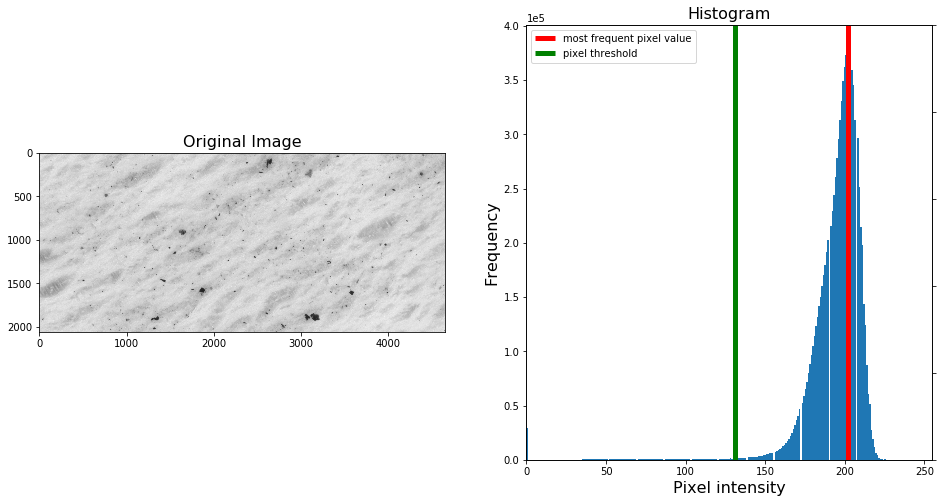

In [8]:
# define number of bins for histogram
bins = 256
#bins = 'auto'
savefig = True

# define relative threshold - default = 65%
th_rel = 0.65

# create figure
fig, ax = plt.subplots(1,2, figsize=(16, 8))

# display original image subset
ax[0].imshow(array, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Original Image', fontsize=16)
xmin, xmax = dtype_range[array.dtype.type]

# calculate histogram and return values
values, bins, bars = ax[1].hist(array.ravel(), bins=bins)

# find the index for the histogram peak
v = np.where(values == values.max())

# get the most frequent pixel value
most_frequent_value = pa.findhistogrammpeak(values, bins)
luminosity = np.round(most_frequent_value / 255 * 100, 0)

# calculate threshold pixel value from relative threshold
threshold = np.round(most_frequent_value * th_rel, 0)

# customize plots
ax[1].set_title('Histogram', fontsize=16)
ax[1].ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax[1].set_xlabel('Pixel intensity', fontsize=16)
ax[1].set_ylabel('Frequency', fontsize=16)
ax[1].set_xlim(xmin, xmax)

# display distribution
axh = ax[1].twinx()
axh.vlines(most_frequent_value, 0, 1, colors='r', linestyles='solid', lw=5, label='most frequent pixel value')
axh.vlines(threshold, 0, 1, colors='g', linestyles='solid', lw=5, label='pixel threshold')
axh.set_ylim(0, 1)
axh.legend(loc='upper left')

# turn off tick labels
axh.set_yticklabels([])

if savefig:
    savename = filename[:-4] + '_Histogram.png'
    fig.savefig(savename, dpi=100, orientation='portrait', transparent=False, frameon=False)

print('Index for this Value      : ', v[0])
print('Most frequent Pixel Value : ', most_frequent_value)
print('Luminosity [%]            : ', luminosity)
print('Relative Treshold Value   : ', th_rel)
print('abs. Treshold Value       : ', threshold)

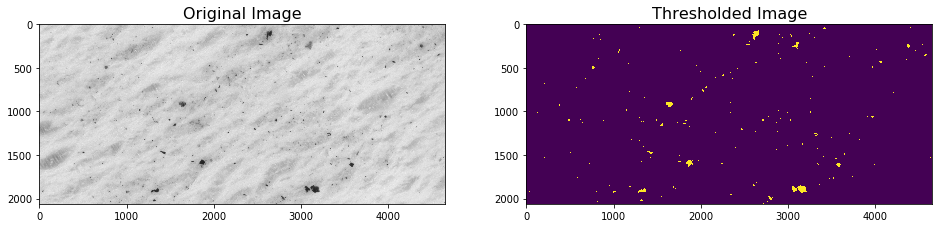

In [9]:
savefig = True

# apply the threshold to the image and invert the result to get the dark particles
th_img = pa.autoThresholding(array, method='value_based', value=threshold)
th_img = invert(th_img)

# dosplay the result
fig, ax = plt.subplots(1,2, figsize=(16, 8))

ax[0].imshow(array, cmap=plt.cm.gray, interpolation='nearest')
ax[1].imshow(th_img)

ax[0].set_title('Original Image', fontsize=16)
ax[1].set_title('Thresholded Image', fontsize=16)
plt.show()

if savefig:
    savename = filename[:-4] + '_Threshold.png'
    fig.savefig(savename, dpi=100, orientation='portrait', transparent=False, frameon=False)

In [10]:
# remover particles from the edge
th_img = clear_border(th_img)

# label the particles
img_label, num_label = label(th_img, background=0, return_num=True, connectivity=2)

print('Initial Number of Particles       : ', num_label)

Initial Number of Particles       :  308


In [13]:
remove_small = True

# remove small objects
if remove_small:
    min_particle_area_micron = 2
    min_particle_size_pixel = np.int(np.round(min_particle_area_micron / (metadata['XScale']**2), 0))
    print('Minimum Particle Size [micron**2] :  {:.2f}'.format(min_particle_area_micron))
    print('Minimum Particle Size [pixel]     :  {:.2f}'.format(min_particle_size_pixel))

    img_label = remove_small_objects(img_label, min_particle_size_pixel, in_place=False)

Minimum Particle Size [micron**2] :  2.00
Minimum Particle Size [pixel]     :  7.00


In [14]:
pclasses = {'A': [0, 5],
            'B': [5, 15],
            'C': [15, 25],
            'D': [25, 50],
            'E': [50, 1000],
            'F': [100, 150],
            'G': [150, 200],
            'H': [200, 400],
            'I': [400, 600],
            'J': [600, 1000],
            'K': [1000, 1500],
            'L': [1500, 2000],
            'M': [2000, 3000],
            'N': [3000, np.inf]
           }

pcolors = {'A': 0,
           'B': 1,
           'C': 2,
           'D': 3,
           'E': 4,
           'F': 5,
           'G': 6,
           'H': 7,
           'I': 8,
           'J': 9,
           'K': 10,
           'L': 11,
           'M': 12,
           'N': 13
           }

Skipped Particles :  99


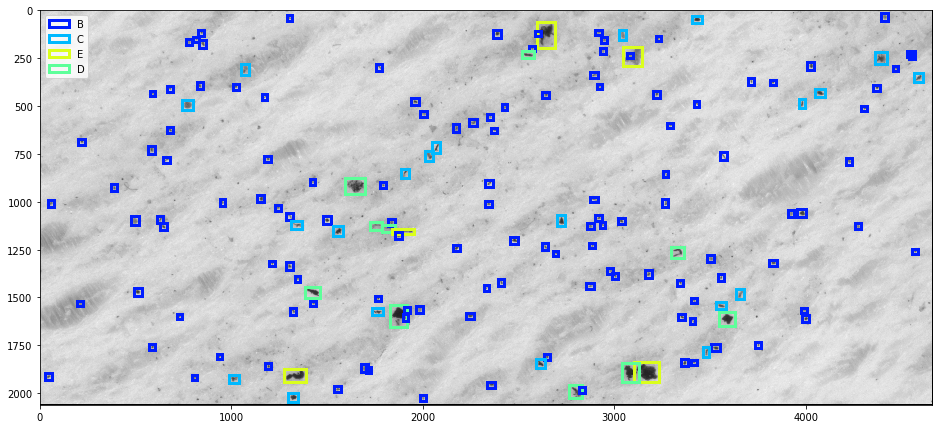

In [15]:
savefig = True

# show original image only and labels (optional)
#image_label_overlay = label2rgb(img_label, image=array, bg_label=0)
#image_label_overlay = img_label
image_label_overlay = array

# display the labelled image
fig, ax_label = plt.subplots(figsize=(16, 16))
ax_label.imshow(image_label_overlay, cmap=plt.cm.gray, interpolation='nearest')

# minimum value for parameter to digard a particle
mv_feretmax = 5

# offset to make bounding boxes a "bit bigger"
offset = 10
drawrect = True

# create emtpy dictionary for all the particles and lust for particle classes
objects = {}
#particleclasses = []

skipped = 0

# loop over all detected objects
for region in regionprops(img_label, intensity_image=array, cache=True, coordinates='xy'):
    
    #properties = pa.get_particleproperties(region, img_label, array, pclasses, pcolors, scaleXY=metainfo['XScale'])
    properties = pa.get_particleproperties(region, img_label, array, pclasses, pcolors, scaleXY=metadata['XScale'])
    
    # store parameters of current object in dictionary for all objects
    objects[region.label] = properties

    if drawrect and objects[region.label]['FeretMax'] >= mv_feretmax:
        # draw rectangle around segmented particles and make the bounding rectangle bigger
        ax, rect = pa.create_rectangles(ax_label, properties, region, offset=offset, lw=3)
        
    # check for small particles and delete entry from dict
    if objects[region.label]['FeretMax'] < mv_feretmax:
        objects.pop(region.label, None)
        skipped = skipped + 1

print('Skipped Particles : ', skipped)

if savefig:
    savename = filename[:-4] + '_Detections.png'
    fig.savefig(savename, dpi=100, orientation='portrait', transparent=False, frameon=False)

In [16]:
# count number of particles and fibers
num_all_objects, num_fibers, num_particles, num_ND = pa.count_objecttypes(objects)

# calculate number of needed columns and rows for particle grid plot
nr, nc = pa.calc_grid(num_all_objects)

# create list with all particle IDs
ids = list(objects)

print('All Objects :', num_all_objects)
print('Particles   :', num_particles)
print('Fibers      :', num_fibers)
print('Not Defined :', num_ND)

All Objects : 160
Particles   : 160
Fibers      : 0
Not Defined : 0


In [17]:
# get all IDs for particles detected as fibers
fiber_ids = pa.find_fibers(objects)
print('Fiber IDs: ', fiber_ids)

Fiber IDs:  []


In [18]:
savefig = True
id2show = 157
obj = objects[id2show]

print('Class                : ', obj['Class'])
print('Area         [micron]:  {:.2f}'.format(obj['Area']))
print('FeretMax     [micron]:  {:.2f}'.format(obj['FeretMax']))
print('FeretMin     [micron]:  {:.2f}'.format(obj['FeretMin']))
print('FeretRatio           :  {:.2f}'.format(obj['FeretRatio']))
print('FiberLength  [micron]:  {:.2f}'.format(obj['FiberLength']))
print('IsFiber              : ', obj['IsFiber'])
print('Perimeter    [micron]:  {:.2f}'.format(obj['Perimeter']))
print('Diameter MIC [micron]:  {:.2f}'.format(obj['maxMIC']))

fig, axobj = plt.subplots(figsize=(8, 8))

if obj['IsFiber']:
    axobj.imshow(obj['IntensityImage'], cmap=plt.cm.hot)
if not obj['IsFiber']:
    axobj.imshow(obj['IntensityImage'], cmap='viridis')

axobj.set_facecolor('grey')
axobj.set_title('Particle ID:' + str(id2show) + ' - Class:' + obj['Class'] + ' - IsFiber:' + str(obj['IsFiber']))

if savefig:
    savename = filename[:-4] + '_ID=' + str(id2show) + '.png'
    fig.savefig(savename, dpi=100, orientation='portrait', transparent=False, frameon=False)

KeyError: 157

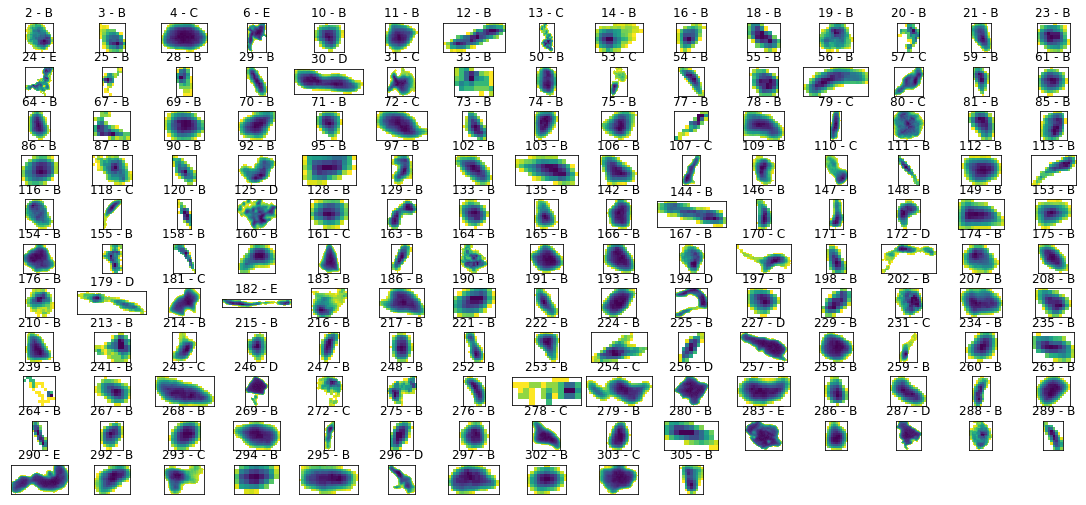

In [19]:
showgridplot = True
savefig = True
maxcols = 15

if showgridplot:

    # create subplots
    fig, axp = plt.subplots(nrows=nr, ncols=maxcols, figsize=(16, 16), subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(left=0.03, right=0.97, hspace=0.5, wspace=0.05)

    count = 0

    for axpp, pid in zip(axp.flat, ids):

        count = count + 1

        # extract the image of the current particle
        p = objects[pid]['IntensityImage']
        c = objects[pid]['Class']

        if objects[pid]['IsFiber']:
            axpp.imshow(p, cmap=plt.cm.hot, interpolation='nearest')

        if not objects[pid]['IsFiber']:
            axpp.imshow(p, cmap='viridis', interpolation='nearest')

        axpp.set_title(str(pid) + ' - ' + c)
        axpp.set_facecolor('white')

    # remove empty axes
    for ad in range(num_particles, nr*maxcols):
        fig.delaxes(axp.flatten()[ad])
        
    if savefig:
        savename = filename[:-4] + '_Grid.png'
        fig.savefig(savename, dpi=100, orientation='portrait', transparent=False, frameon=False)

In [20]:
# create list for a specific parameter
parameters = []
paramstring = 'FeretMax'

for k in objects.keys():
    parameters.append(objects[k][paramstring])
    
param_array = np.asarray(parameters)
param_array.shape

(160,)

Most frequent Value       :  [5.]
Index for this Value      :  [0]
Minimum Particle Size     :  5.00
Maximum Particle Size     :  60.17
Mean Particle Size        :  13.20
Median Particle Size      :  9.80
Std. Dev. Particle Size   :  11.00


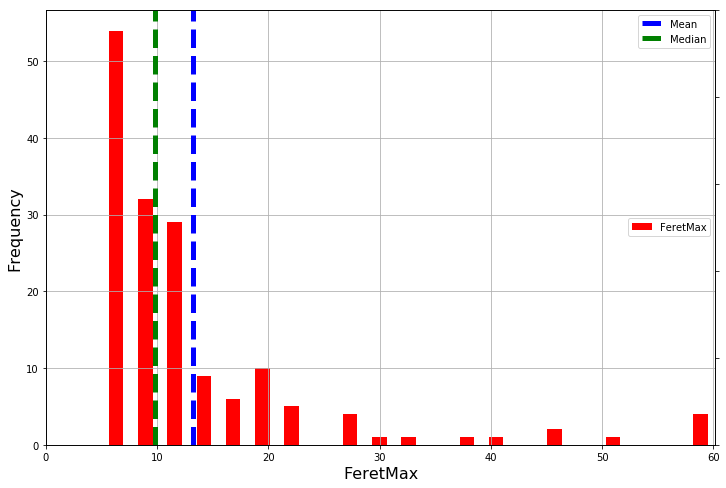

In [21]:
savefig = True

# create figure
fig, ax_area = plt.subplots(1,1, figsize=(12, 8))

# Display histogram and return values
p_values, p_bins, p_bars = ax_area.hist(param_array.ravel(),
                                        bins='auto',
                                        #bins=256,
                                        align='mid',
                                        rwidth=0.5,
                                        log=False,
                                        color='red',
                                        label=paramstring)

# find the index for the highest values
v_param = np.where(p_values == p_values.max())

# get the most frequent pixel value
p_most_frequent_value = pa.findhistogrammpeak(p_values, p_bins)

p_mean = np.round(param_array.mean(), 1)
p_median = np.round(np.median(param_array), 1)
p_std = np.round(param_array.std(), 1)

#ax_area.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax_area.set_xlabel(paramstring, fontsize=16)
ax_area.set_ylabel('Frequency', fontsize=16)
ax_area.set_xlim(0, param_array.max())
ax_area.grid(True)
ax_area.legend(loc='center right')

# plot vertical lines for mean an median values
ax_area1 = ax_area.twinx()
ax_area1.vlines(p_mean, 0, 1, colors='b', linestyles='dashed', lw=5, label='Mean')
ax_area1.vlines(p_median, 0, 1, colors='g', linestyles='dashed', lw=5, label='Median')
ax_area1.set_ylim(0, 1)
ax_area1.legend(loc='upper right')
# Turn off tick labels
ax_area1.set_yticklabels([])

if savefig:
    savename = filename[:-4] + '_' +paramstring + '_Dist.png'
    fig.savefig(savename, dpi=100, orientation='portrait', transparent=False, frameon=False)

print('Most frequent Value       : ', p_most_frequent_value)
print('Index for this Value      : ', v_param[0])
print('Minimum Particle Size     :  {:.2f}'.format(param_array.min()))
print('Maximum Particle Size     :  {:.2f}'.format(param_array.max()))
print('Mean Particle Size        :  {:.2f}'.format(p_mean))
print('Median Particle Size      :  {:.2f}'.format(p_median))
print('Std. Dev. Particle Size   :  {:.2f}'.format(p_std))

In [22]:
# create pandas dataframe with all particles
df = pd.DataFrame(objects)
df = df.transpose().reset_index()
df = df.drop(['ClassColor', 'LabelImage', 'IntensityImage'], axis=1)
df.rename(index=str, columns={"index": "ParticleID"}, inplace=True)

# define new order of columns
columnsTitles=['ParticleID',
               'Class',
               'Area',
               'IsFiber',
               'FiberLength',
               'FeretMin',
               'FeretMax',
               'FeretRatio',
               'maxMIC',
               'Perimeter']

# do the reindexing and show the dataframe
df= df.reindex(columns=columnsTitles)
df[:10]

,ParticleID,Class,Area,IsFiber,FiberLength,FeretMin,FeretMax,FeretRatio,maxMIC,Perimeter
0,2,B,63.5577,False,0,7.95953,10.2245,1.28456,7.72519,29.4655
1,3,B,14.6212,False,0,3.48398,5.52757,1.58657,3.93909,14.0346
2,4,C,132.785,False,0,10.325,16.4909,1.59719,10.9251,43.9881
3,6,E,1349.93,False,370.617,34.0587,59.642,1.75116,29.5179,197.903
4,10,B,24.7666,False,0,5.46448,5.88921,1.07773,4.88584,18.0103
5,11,B,92.5018,False,0,10.4153,11.5913,1.11291,9.77168,36.6605
6,12,B,25.065,False,9.28227,2.93142,11.1806,3.81405,3.45481,23.3791
7,13,C,71.6143,False,24.4139,6.2867,16.698,2.65608,6.18015,42.7082
8,14,B,22.9762,False,0,4.14467,7.1465,1.72426,4.37003,17.6515
9,16,B,12.8309,False,0,3.33504,5.00319,1.50019,3.09008,12.7352


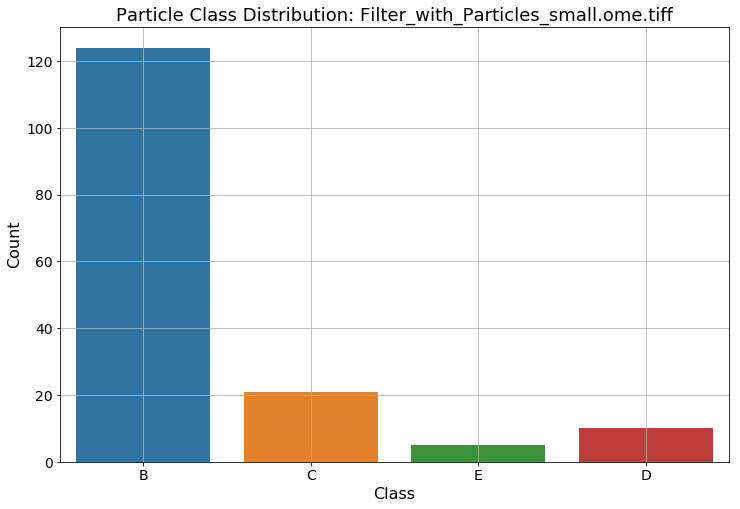

In [23]:
savefig = True

# display the result for the particle classes and their respective counts
fig, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.countplot(x="Class", data=df)
ax.grid(True)

ax.set_title('Particle Class Distribution: ' + os.path.basename(filename), fontsize = 18)
ax.set_xlabel('Class', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)

if savefig:
    savename = filename[:-4] + '_ClassCounts.png'
    fig.savefig(savename, dpi=100, orientation='portrait', transparent=False, frameon=False)

In [24]:
# write data to excel sheet and csv
write2excel = True
write2csv = True


# get filename without extension
basename_woext = os.path.basename(filename).split('.')[0]
basepath = os.path.dirname(filename)

# define name for excelsheet and csvtable
excelfile = os.path.join(basepath, basename_woext + '_PA_Results.xlsx')
csvfile = os.path.join(basepath, basename_woext + '_PA_Results.csv')

if write2excel:
    # check for an already existing file and skip saving it in case it exists already
    resultfile_excel = Path(excelfile)
    if not resultfile_excel.is_file():
        writer = pd.ExcelWriter(excelfile)
        df.to_excel(writer,'Particle Analysis Results')
        writer.save()
        print('Saved results Excel :', excelfile)

    elif resultfile_excel.is_file():
        print('Excel File already exits. Did not write anything.')
    
if write2csv:
    # check for an already existing file and skip saving it in case it exists already
    resultfile_csv = Path(csvfile)
    if not resultfile_csv.is_file():
        df.to_csv(csvfile, index=False, header=True, decimal='.', sep='\t')
        print('Saved results CSV :', csvfile)

    elif resultfile_csv.is_file():
        print('CSV File already exits. Did not write anything.')

Saved results Excel : Filter_with_Particles_small_PA_Results.xlsx
Saved results CSV : Filter_with_Particles_small_PA_Results.csv


cd c:\Users\m1srh\OneDrive - Carl Zeiss AG\IPython_Notebooks\ZEN_Wellplate_Analysis_Pandas\

jupyter nbconvert ZEN_Wellplate_Analysis_Pandas_Translocation_Tutorial.ipynb --to slides --post serve

jupyter nbconvert ZEN_Wellplate_Analysis_Pandas_Translocation_Tutorial.ipynb --to slides --post serve --SlidesExporter.reveal_theme=serif --SlidesExporter.reveal_scroll=True --SlidesExporter.reveal_transition=none